# Dynamically Expandable Network

Notebook brouillon

## Imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import logging as log
import re
import random
import collections
import time

import matplotlib.pyplot as plt
import numpy as np

## Chargement des datasets

Basé sur le code fourni dans [la documentation de PyTorch](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [2]:
# Conversion sortie torchvision en tenseur normalisé
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Affichage image dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [3]:
cifar10_train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
cifar10_train_loader = torch.utils.data.DataLoader(cifar10_train_set, batch_size=4,
                                          shuffle=True, num_workers=2)

cifar10_test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
cifar10_test_loader = torch.utils.data.DataLoader(cifar10_test_set, batch_size=4,
                                         shuffle=False, num_workers=2)

cifar10_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
mnist_train_set = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
mnist_train_loader = torch.utils.data.DataLoader(mnist_train_set, batch_size=4,
                                          shuffle=True, num_workers=2)

mnist_test_set = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
mnist_test_loader = torch.utils.data.DataLoader(mnist_test_set, batch_size=4,
                                         shuffle=False, num_workers=2)

mnist_classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

lsun_train_set = torchvision.datasets.PhotoTour(root='./data', train=True,
                                        download=True, transform=transform)
lsun_train_loader = torch.utils.data.DataLoader(stl10_train_set, batch_size=4,
                                          shuffle=True, num_workers=2)

lsun_test_set = torchvision.datasets.PhotoTour(root='./data', train=False,
                                       download=True, transform=transform)
lsun_test_loader = torch.utils.data.DataLoader(stl10_test_set, batch_size=4,
                                         shuffle=False, num_workers=2)

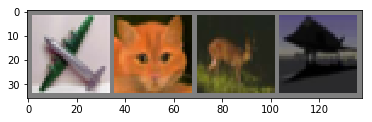

plane   cat  deer plane


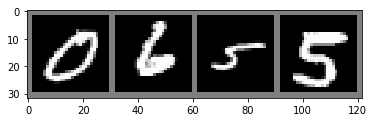

    0     6     5     5


In [5]:
# get some random training images
dataiter = iter(cifar10_train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
plt.show()
# print labels
print(' '.join('%5s' % cifar10_classes[labels[j]] for j in range(4)))


# get some random training images
dataiter = iter(mnist_train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
plt.show()
# print labels
print(' '.join('%5s' % mnist_classes[labels[j]] for j in range(4)))

In [6]:
dataiter = iter(cifar10_train_loader)
images, labels = dataiter.next()
images[0].shape

torch.Size([3, 32, 32])

Process Process-6:
  File "/home/anti/.anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
Process Process-5:
Traceback (most recent call last):
  File "/home/anti/.anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/anti/.anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/anti/.anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/home/anti/.anaconda3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/home/anti/.anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/anti/.anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._k

## Création des modèles baseline

Basé sur le code fourni dans [la documentation de PyTorch](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [7]:
class ConvolutionalNet(nn.Module):
    def __init__(self):
        super(ConvolutionalNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = ConvolutionalNet()

# Modèle simple 2 couches

In [8]:
simple_net = nn.Sequential(nn.Linear(784, 312),
                           nn.ReLU(),
                           nn.Linear(312, 128),
                           nn.ReLU(),
                           nn.Linear(128, 1),
                           nn.ReLU())

In [9]:
ml = nn.MSELoss()
ite = 500
opt = optim.SGD(simple_net.parameters(), lr=1e-3)

lossHisto = []
scoreHisto = []

for i,(x,yN) in enumerate(mnist_train_loader):
    if i > ite :
        break
    if i%(ite/10) == 0:
        print("Iteration", i)
    
    x = Variable(x.view(-1,784))
        
    y_onehot = torch.FloatTensor(*yN.size(), 10).zero_()
    y_onehot.scatter_(1, torch.unsqueeze(yN, 1), 1)
    y = Variable(y_onehot)
    
    f = simple_net.forward(x)
    loss = ml.forward(f, y)
    loss.backward()
    opt.step()
    
    lossHisto.append(loss.data.mean())
    ypred = torch.max(f, 1)[1]
    scoreHisto.append(torch.eq(ypred.data, yN).float().mean())
    
plt.plot(lossHisto)
plt.ylabel('loss')
plt.xlabel('nb batch traited')
plt.show()
plt.plot(scoreHisto)
plt.ylabel('score')
plt.xlabel('nb batch traited')
plt.show()

Iteration 0


RuntimeError: input and target have different number of elements: input[4 x 1] has 4 elements, while target[4 x 10] has 40 elements at /opt/conda/conda-bld/pytorch_1513368888240/work/torch/lib/THNN/generic/MSECriterion.c:13

In [10]:
for module in simple_net.modules():
    print(module, list(module.named_parameters()))
    for param in module.parameters():
        print(type(param.data), param.size())

Sequential(
  (0): Linear(in_features=784, out_features=312)
  (1): ReLU()
  (2): Linear(in_features=312, out_features=128)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=1)
  (5): ReLU()
) [('0.weight', Parameter containing:
1.00000e-02 *
 2.4430  2.2946 -2.7040  ...  -3.4490 -2.5599  2.5554
 2.9342 -1.3815  3.3293  ...  -0.0258 -3.4980  0.9784
 0.2694  0.0960  2.5989  ...  -0.4233 -0.7054  0.5814
          ...             ⋱             ...          
 1.6376 -2.0245 -0.3618  ...   0.1095 -3.3526 -2.7642
 2.2282  3.3042  2.0327  ...   2.0718  0.5831  2.8283
-1.6964 -0.3136 -0.2982  ...   0.9535 -3.3794 -1.0390
[torch.FloatTensor of size 312x784]
), ('0.bias', Parameter containing:
1.00000e-02 *
  3.3245
 -1.1272
  0.2989
  0.4016
 -2.0787
  2.7111
  2.2583
 -2.0183
  1.9912
  2.5460
 -1.9892
 -0.5887
  3.4725
 -0.8597
  2.9116
  2.6850
 -0.9911
 -2.7273
 -0.6369
 -3.2218
  2.2877
 -2.0243
  1.9236
 -0.8457
 -2.9674
 -3.3407
  1.7827
  1.1198
  1.6642
  2.9539
  1.6446
  1.12

## Modèle DEN

Basé sur les explications et algorithmes proposés par l'article

In [11]:
import pandas as pd

In [12]:
mnist_variation_train = pd.read_csv('./data/mnist_variation/mnist_all_background_images_rotation_normalized_train_valid.amat', delim_whitespace=True, header=None, names=[str(i) for i in range(784)] + ['label'])

In [13]:
mnist_variation_train_set = torch.utils.data.TensorDataset(
    torch.from_numpy(mnist_variation_train.as_matrix([str(i) for i in range(784)])).float(),
    torch.from_numpy(mnist_variation_train['label'].values).float(),
)
mnist_variation_train_set_loader = torch.utils.data.DataLoader(mnist_variation_train_set, batch_size=50, shuffle=True)


mnist_class_train_set = {c : [] for c in mnist_classes}

mnist_class_train_set

for i, (x, y) in enumerate(mnist_train_loader):
    mnist_class_train_set[y].append(x)

In [21]:
simple_net = nn.Sequential(nn.Linear(784, 312),
                           nn.ReLU(),
                           nn.Linear(312, 128),
                           nn.ReLU(),
                           nn.Linear(128, 1),
                           nn.ReLU())

In [22]:
from algoDEN import DEN
import itertools
import numpy as np
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

DEN mu =  0.0  lr =  0.0
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


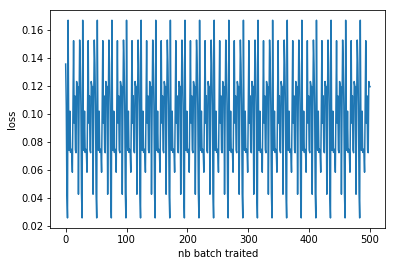

0.11924468725919724
Traitement effectué en 10.254950284957886 secondes.

DEN mu =  0.0  lr =  2.5e-05
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


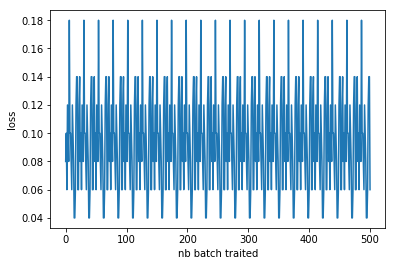

0.05999999865889549
Traitement effectué en 9.954425573348999 secondes.

DEN mu =  0.0  lr =  5e-05
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


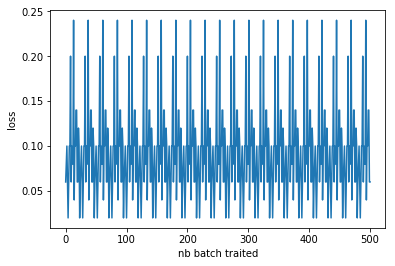

0.05999999865889549
Traitement effectué en 10.294328927993774 secondes.

DEN mu =  0.0  lr =  7.5e-05
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


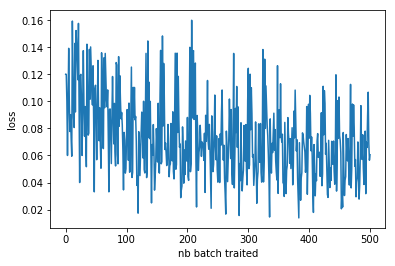

0.06055838242173195
Traitement effectué en 10.181514978408813 secondes.

DEN mu =  0.0  lr =  0.0001
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


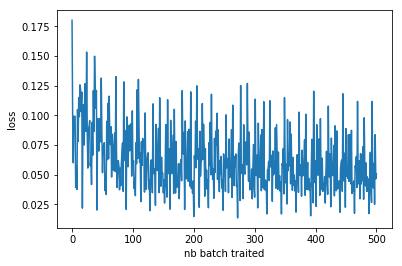

0.05061926692724228
Traitement effectué en 10.159170150756836 secondes.

DEN mu =  0.0  lr =  0.000125
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


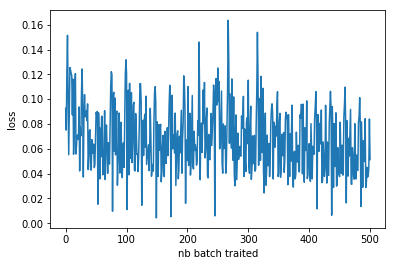

0.05130042880773544
Traitement effectué en 10.286281108856201 secondes.

DEN mu =  0.0  lr =  0.00015
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


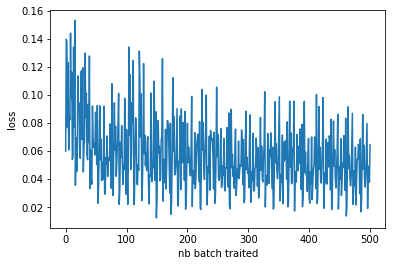

0.06468729674816132
Traitement effectué en 10.149285793304443 secondes.

DEN mu =  0.0  lr =  0.000175
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


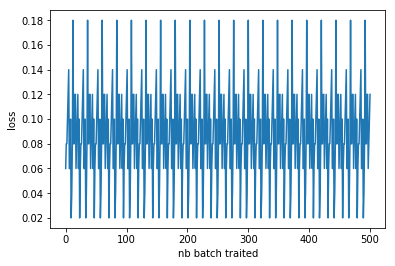

0.11999999731779099
Traitement effectué en 10.354702234268188 secondes.

DEN mu =  0.0  lr =  0.0002
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


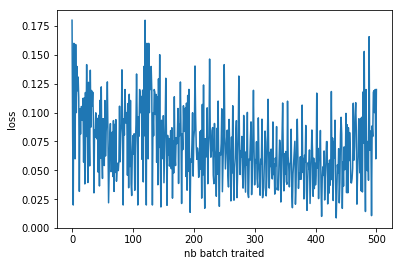

0.11999999731779099
Traitement effectué en 10.247634649276733 secondes.

DEN mu =  0.0  lr =  0.000225
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


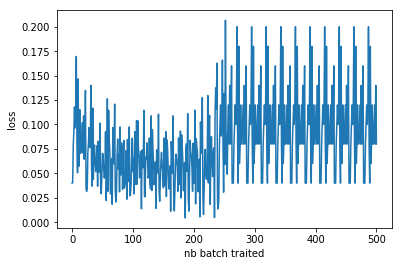

0.07999999821186066
Traitement effectué en 10.245731592178345 secondes.

DEN mu =  0.0  lr =  0.00025
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


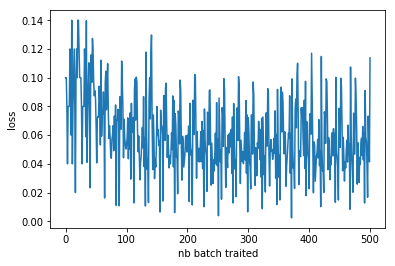

0.11378955841064453
Traitement effectué en 10.117437839508057 secondes.

DEN mu =  0.0  lr =  0.000275
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


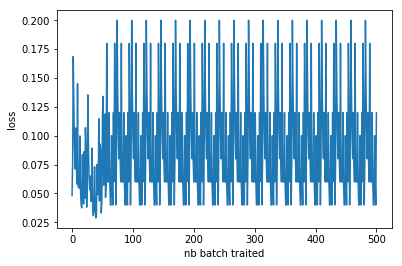

0.11999999731779099
Traitement effectué en 10.11475944519043 secondes.

DEN mu =  0.1  lr =  0.0
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


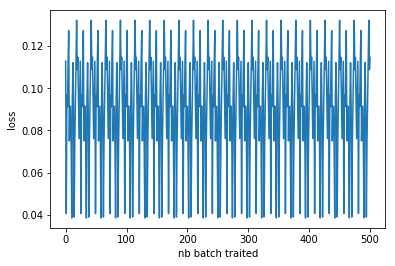

0.11466121673583984
Traitement effectué en 10.204868793487549 secondes.

DEN mu =  0.1  lr =  2.5e-05
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


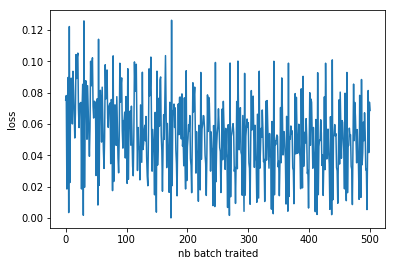

0.06864257901906967
Traitement effectué en 10.240997076034546 secondes.

DEN mu =  0.1  lr =  5e-05
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


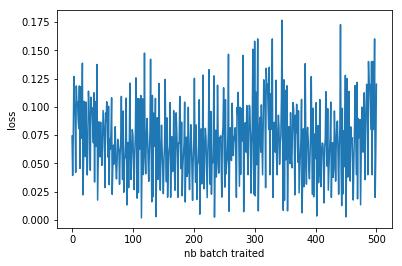

0.11999999731779099
Traitement effectué en 10.285074949264526 secondes.

DEN mu =  0.1  lr =  7.5e-05
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


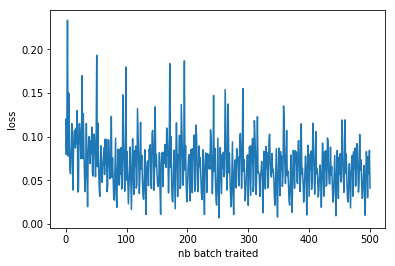

0.04104017838835716
Traitement effectué en 10.258077383041382 secondes.

DEN mu =  0.1  lr =  0.0001
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


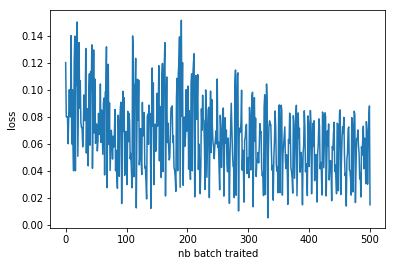

0.014863485470414162
Traitement effectué en 10.22907018661499 secondes.

DEN mu =  0.1  lr =  0.000125
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


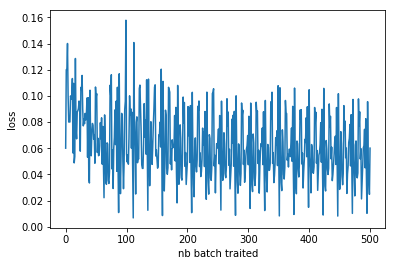

0.06004316359758377
Traitement effectué en 10.173661708831787 secondes.

DEN mu =  0.1  lr =  0.00015
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


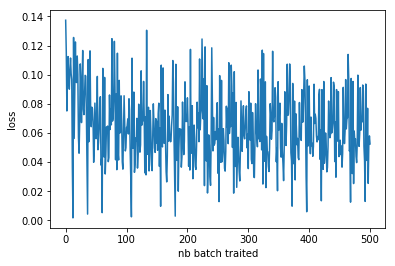

0.05247512832283974
Traitement effectué en 10.047470331192017 secondes.

DEN mu =  0.1  lr =  0.000175
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


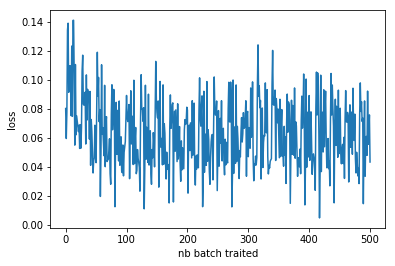

0.0432884581387043
Traitement effectué en 10.179229736328125 secondes.

DEN mu =  0.1  lr =  0.0002
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


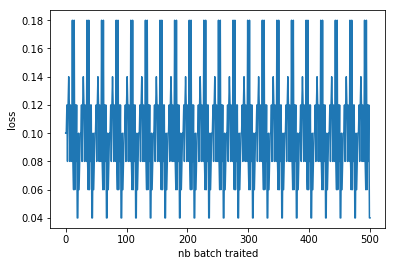

0.03999999910593033
Traitement effectué en 10.263674259185791 secondes.

DEN mu =  0.1  lr =  0.000225
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


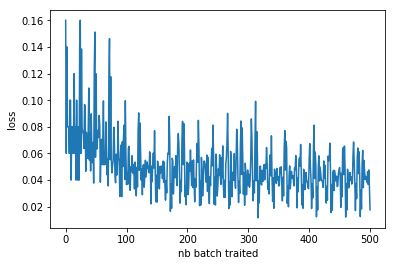

0.017646681517362595
Traitement effectué en 10.191425323486328 secondes.

DEN mu =  0.1  lr =  0.00025
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


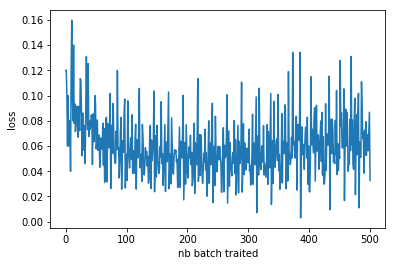

0.032708778977394104
Traitement effectué en 10.1960129737854 secondes.

DEN mu =  0.1  lr =  0.000275
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


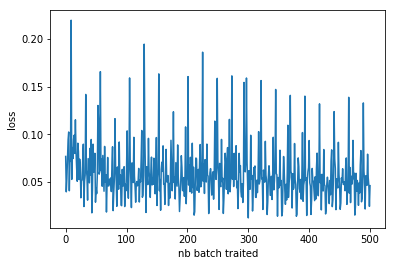

0.0461726076900959
Traitement effectué en 10.163585662841797 secondes.

DEN mu =  0.2  lr =  0.0
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


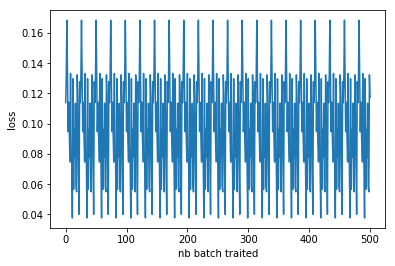

0.11735441535711288
Traitement effectué en 10.319122552871704 secondes.

DEN mu =  0.2  lr =  2.5e-05
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


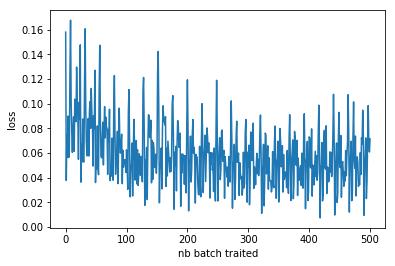

0.07154006510972977
Traitement effectué en 10.152332067489624 secondes.

DEN mu =  0.2  lr =  5e-05
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


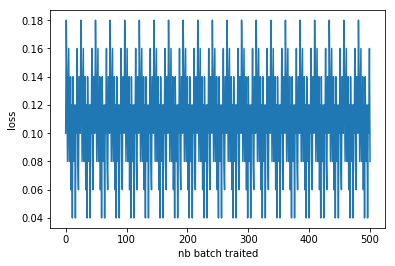

0.07999999821186066
Traitement effectué en 10.300545930862427 secondes.

DEN mu =  0.2  lr =  7.5e-05
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


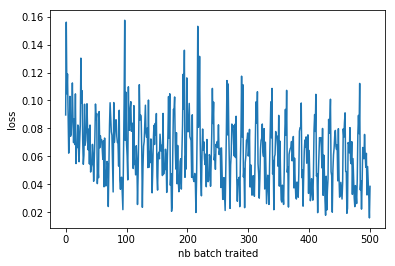

0.03851268067955971
Traitement effectué en 10.246994018554688 secondes.

DEN mu =  0.2  lr =  0.0001
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


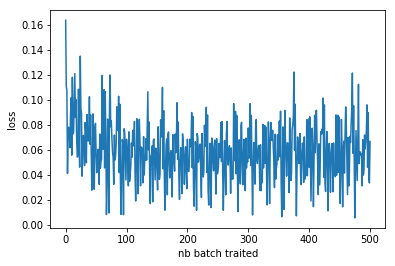

0.06649383902549744
Traitement effectué en 10.07739543914795 secondes.

DEN mu =  0.2  lr =  0.000125
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


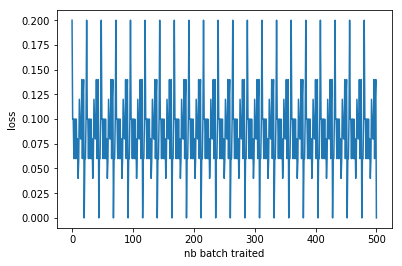

0.0
Traitement effectué en 10.147636413574219 secondes.

DEN mu =  0.2  lr =  0.00015
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


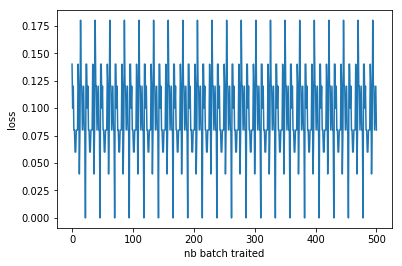

0.07999999821186066
Traitement effectué en 10.233734369277954 secondes.

DEN mu =  0.2  lr =  0.000175
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


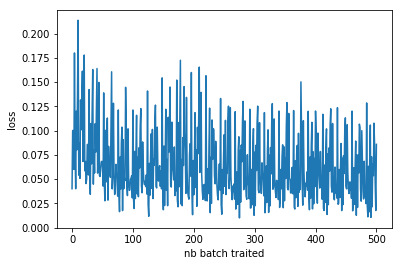

0.08575145900249481
Traitement effectué en 10.17415165901184 secondes.

DEN mu =  0.2  lr =  0.0002
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


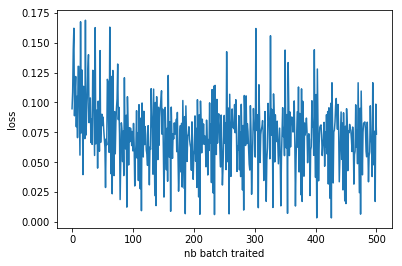

0.07355077564716339
Traitement effectué en 10.307663917541504 secondes.

DEN mu =  0.2  lr =  0.000225
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


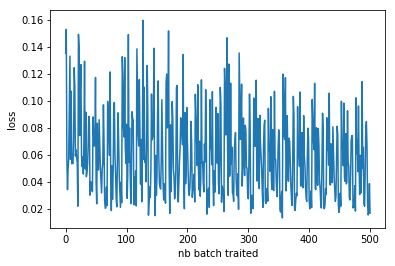

0.016956355422735214
Traitement effectué en 10.177326202392578 secondes.

DEN mu =  0.2  lr =  0.00025
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


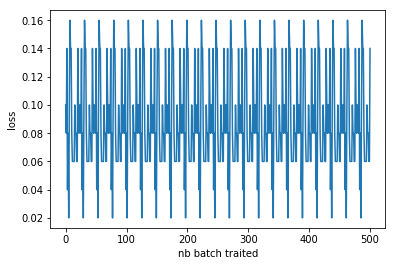

0.14000000059604645
Traitement effectué en 10.06734561920166 secondes.

DEN mu =  0.2  lr =  0.000275
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


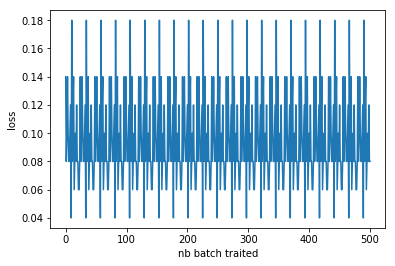

0.07999999821186066
Traitement effectué en 10.209575653076172 secondes.

DEN mu =  0.3  lr =  0.0
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


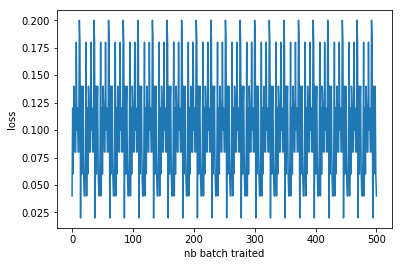

0.03999999910593033
Traitement effectué en 10.113565683364868 secondes.

DEN mu =  0.3  lr =  2.5e-05
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


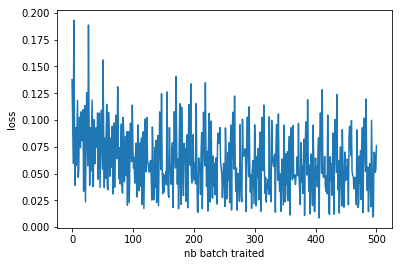

0.07617735862731934
Traitement effectué en 10.256465673446655 secondes.

DEN mu =  0.3  lr =  5e-05
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


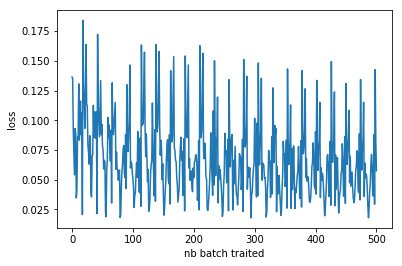

0.05740155279636383
Traitement effectué en 10.19039511680603 secondes.

DEN mu =  0.3  lr =  7.5e-05
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


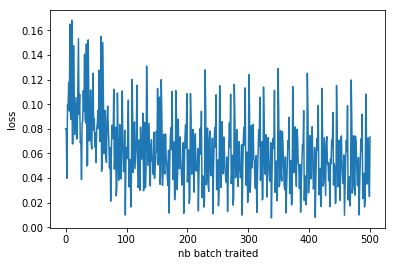

0.07337765395641327
Traitement effectué en 10.14503026008606 secondes.

DEN mu =  0.3  lr =  0.0001
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


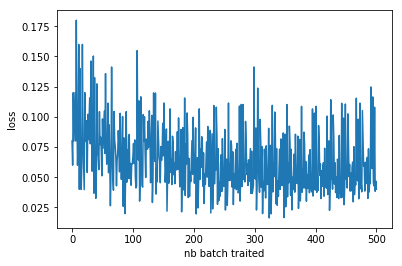

0.04002721235156059
Traitement effectué en 10.04268741607666 secondes.

DEN mu =  0.3  lr =  0.000125
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


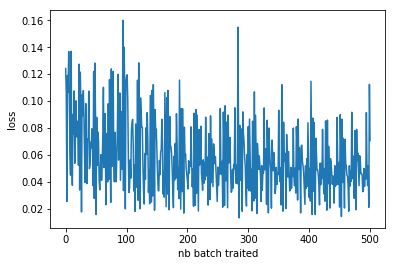

0.07072441279888153
Traitement effectué en 10.216787099838257 secondes.

DEN mu =  0.3  lr =  0.00015
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


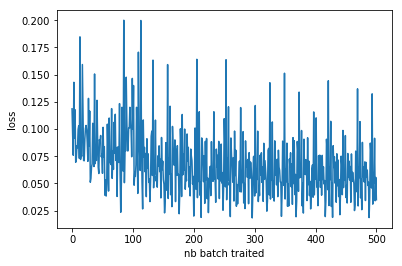

0.03504584729671478
Traitement effectué en 10.27533745765686 secondes.

DEN mu =  0.3  lr =  0.000175
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


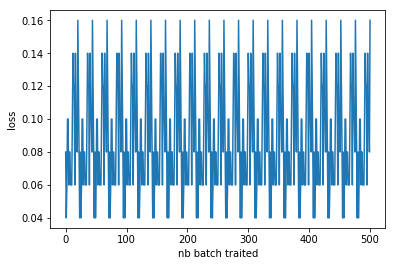

0.1599999964237213
Traitement effectué en 10.368760347366333 secondes.

DEN mu =  0.3  lr =  0.0002
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


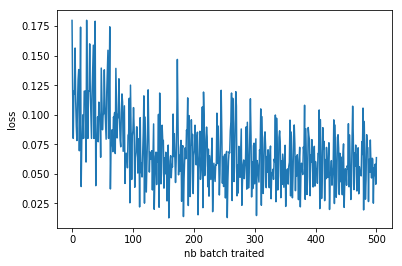

0.06372196972370148
Traitement effectué en 10.163731336593628 secondes.

DEN mu =  0.3  lr =  0.000225
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


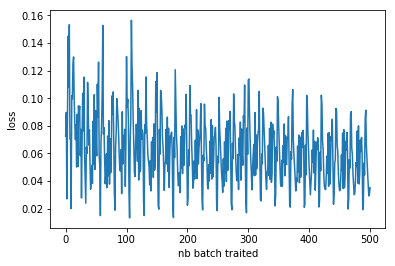

0.03528362140059471
Traitement effectué en 10.256223917007446 secondes.

DEN mu =  0.3  lr =  0.00025
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


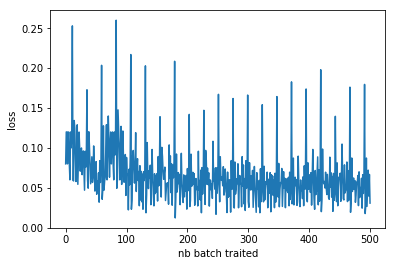

0.03084724396467209
Traitement effectué en 10.073703527450562 secondes.

DEN mu =  0.3  lr =  0.000275
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


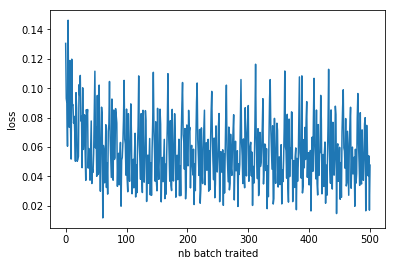

0.04769985377788544
Traitement effectué en 10.243923425674438 secondes.

DEN mu =  0.4  lr =  0.0
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


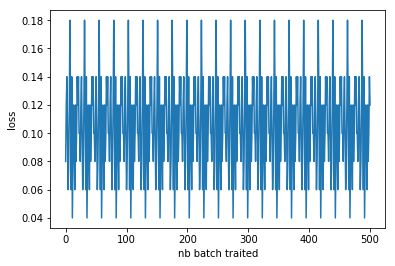

0.11999999731779099
Traitement effectué en 10.234939336776733 secondes.

DEN mu =  0.4  lr =  2.5e-05
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


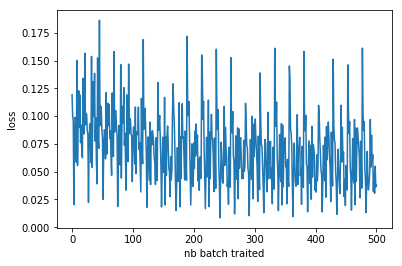

0.03781382739543915
Traitement effectué en 10.162903070449829 secondes.

DEN mu =  0.4  lr =  5e-05
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


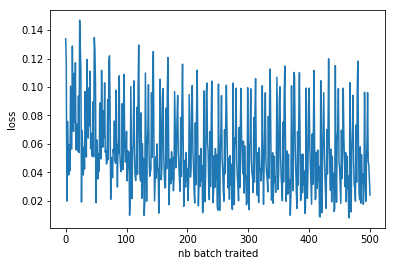

0.024126674979925156
Traitement effectué en 10.120494604110718 secondes.

DEN mu =  0.4  lr =  7.5e-05
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


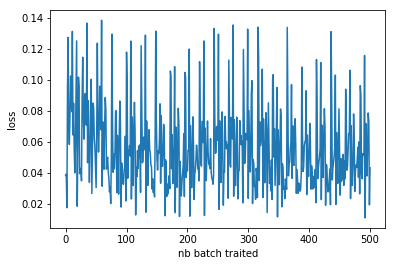

0.04319155588746071
Traitement effectué en 10.185335874557495 secondes.

DEN mu =  0.4  lr =  0.0001
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


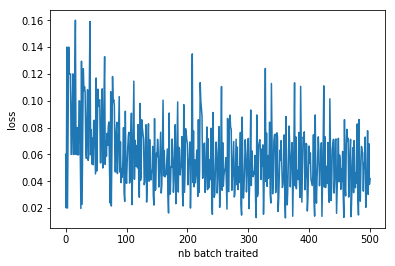

0.04187985509634018
Traitement effectué en 10.14665174484253 secondes.

DEN mu =  0.4  lr =  0.000125
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


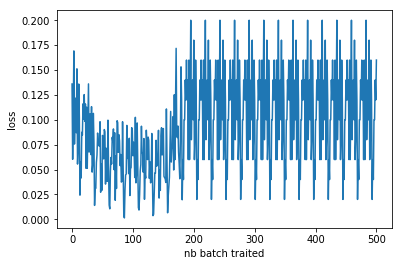

0.1599999964237213
Traitement effectué en 10.244869947433472 secondes.

DEN mu =  0.4  lr =  0.00015
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


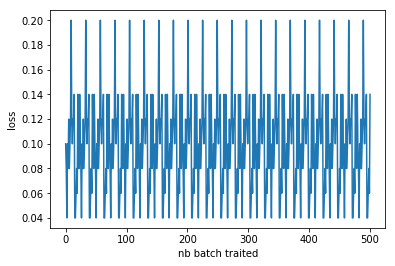

0.14000000059604645
Traitement effectué en 10.149401903152466 secondes.

DEN mu =  0.4  lr =  0.000175
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


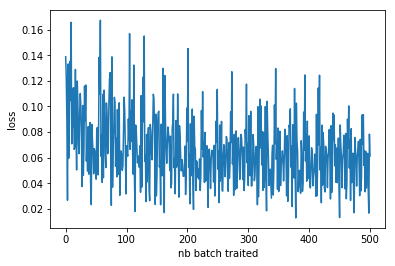

0.06142010539770126
Traitement effectué en 10.068586826324463 secondes.

DEN mu =  0.4  lr =  0.0002
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


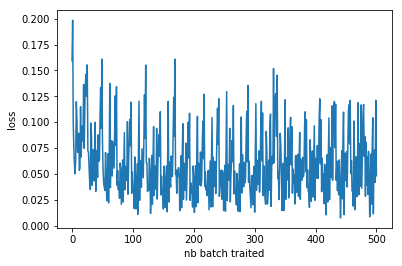

0.04813001677393913
Traitement effectué en 10.155715227127075 secondes.

DEN mu =  0.4  lr =  0.000225
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


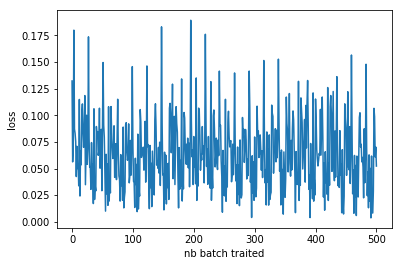

0.05227256193757057
Traitement effectué en 10.326237201690674 secondes.

DEN mu =  0.4  lr =  0.00025
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


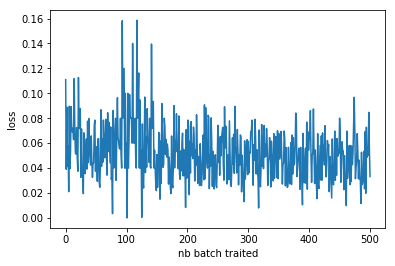

0.03324972465634346
Traitement effectué en 10.002083539962769 secondes.

DEN mu =  0.4  lr =  0.000275
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


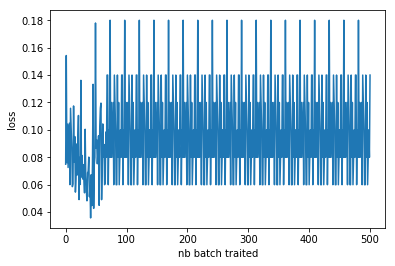

0.14000000059604645
Traitement effectué en 10.278438091278076 secondes.

DEN mu =  0.5  lr =  0.0
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


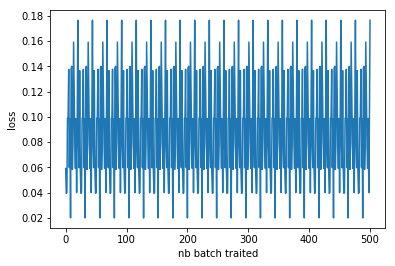

0.1763201355934143
Traitement effectué en 10.264160871505737 secondes.

DEN mu =  0.5  lr =  2.5e-05
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


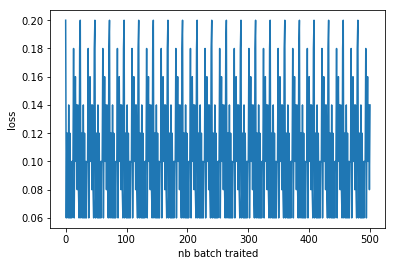

0.14000000059604645
Traitement effectué en 10.148316144943237 secondes.

DEN mu =  0.5  lr =  5e-05
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


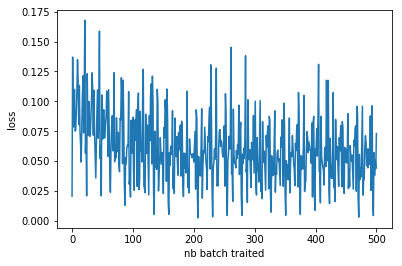

0.07307174056768417
Traitement effectué en 10.282643556594849 secondes.

DEN mu =  0.5  lr =  7.5e-05
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


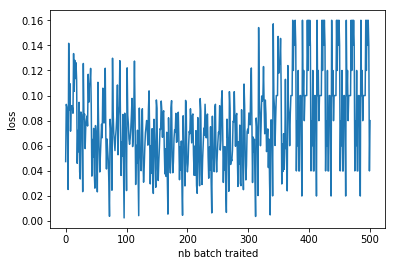

0.07999999821186066
Traitement effectué en 10.156867027282715 secondes.

DEN mu =  0.5  lr =  0.0001
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


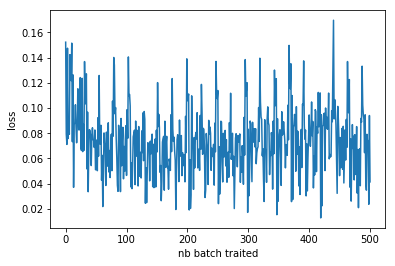

0.04138023406267166
Traitement effectué en 10.037569046020508 secondes.

DEN mu =  0.5  lr =  0.000125
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


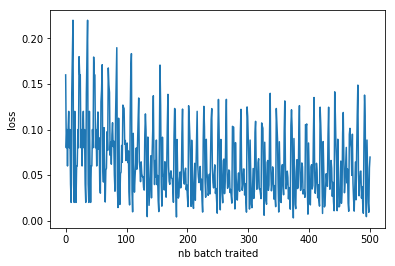

0.06976520270109177
Traitement effectué en 10.229600429534912 secondes.

DEN mu =  0.5  lr =  0.00015
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


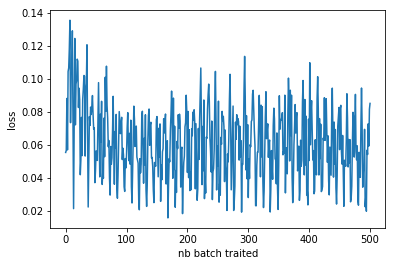

0.0850251093506813
Traitement effectué en 10.330935955047607 secondes.

DEN mu =  0.5  lr =  0.000175
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


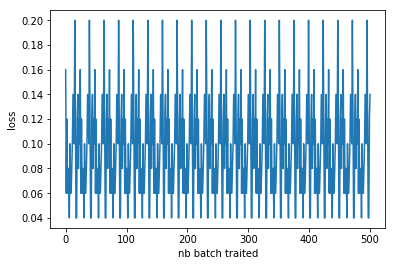

0.14000000059604645
Traitement effectué en 10.221004724502563 secondes.

DEN mu =  0.5  lr =  0.0002
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


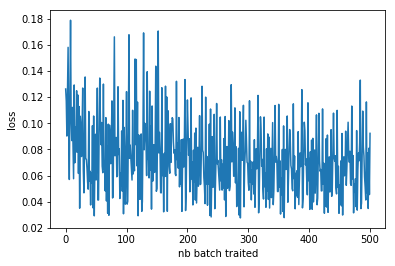

0.09227777272462845
Traitement effectué en 10.223126411437988 secondes.

DEN mu =  0.5  lr =  0.000225
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


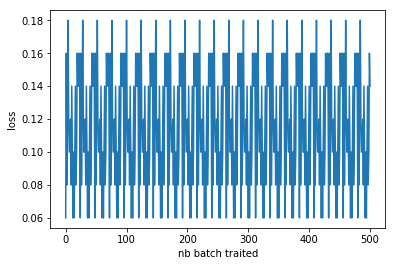

0.14000000059604645
Traitement effectué en 9.956648349761963 secondes.

DEN mu =  0.5  lr =  0.00025
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


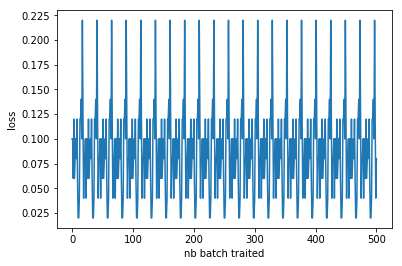

0.07999999821186066
Traitement effectué en 9.92817997932434 secondes.

DEN mu =  0.5  lr =  0.000275
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


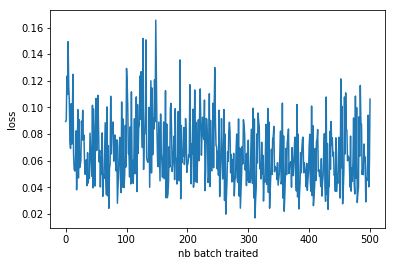

0.1062120795249939
Traitement effectué en 10.147104740142822 secondes.

DEN mu =  0.6  lr =  0.0
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


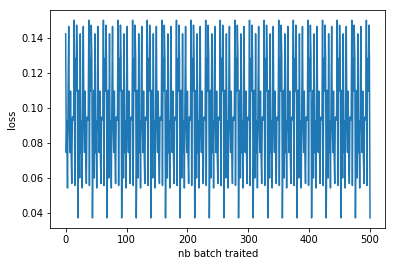

0.03712641820311546
Traitement effectué en 10.144424438476562 secondes.

DEN mu =  0.6  lr =  2.5e-05
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


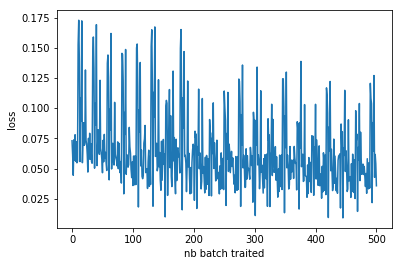

0.035712409764528275
Traitement effectué en 10.198762893676758 secondes.

DEN mu =  0.6  lr =  5e-05
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


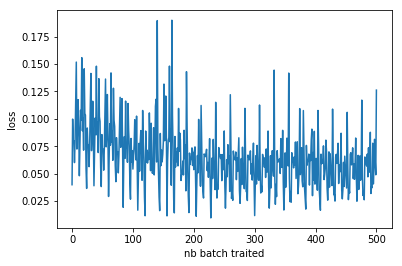

0.12622284889221191
Traitement effectué en 10.092292785644531 secondes.

DEN mu =  0.6  lr =  7.5e-05
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


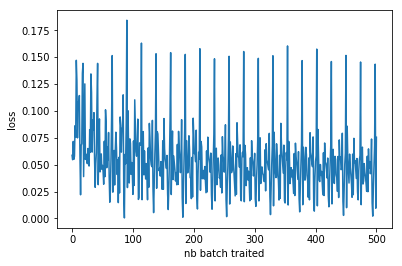

0.07542868703603745
Traitement effectué en 10.093248844146729 secondes.

DEN mu =  0.6  lr =  0.0001
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


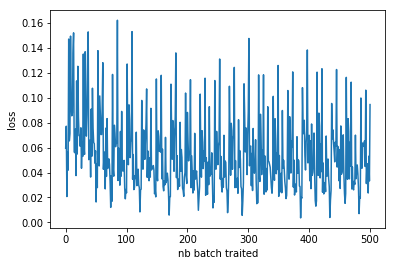

0.09456662833690643
Traitement effectué en 9.9098641872406 secondes.

DEN mu =  0.6  lr =  0.000125
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


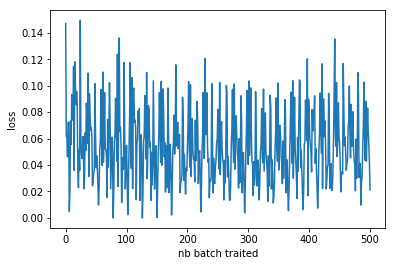

0.021037811413407326
Traitement effectué en 10.210290431976318 secondes.

DEN mu =  0.6  lr =  0.00015
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


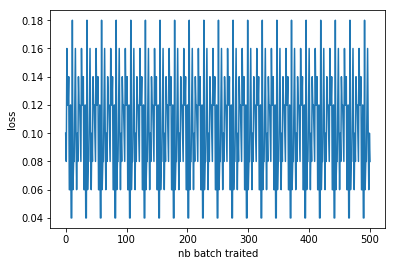

0.07999999821186066
Traitement effectué en 10.051609516143799 secondes.

DEN mu =  0.6  lr =  0.000175
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


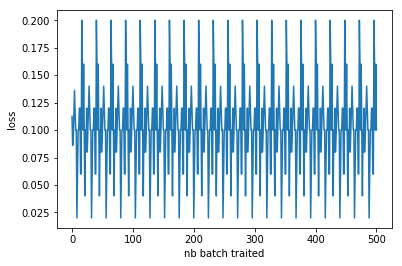

0.10000000149011612
Traitement effectué en 10.127432107925415 secondes.

DEN mu =  0.6  lr =  0.0002
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


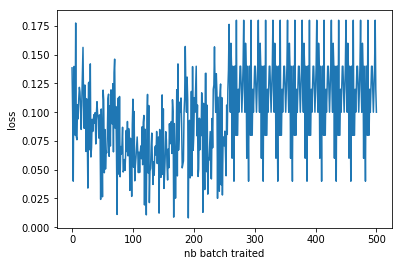

0.10000000149011612
Traitement effectué en 10.081474304199219 secondes.

DEN mu =  0.6  lr =  0.000225
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


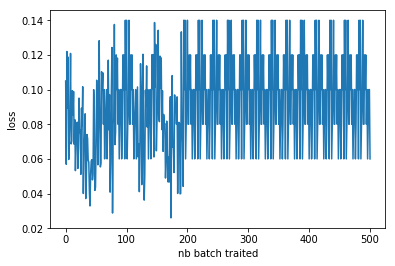

0.05999999865889549
Traitement effectué en 10.2047278881073 secondes.

DEN mu =  0.6  lr =  0.00025
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


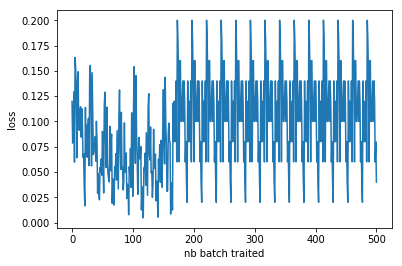

0.03999999910593033
Traitement effectué en 9.944541454315186 secondes.

DEN mu =  0.6  lr =  0.000275
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


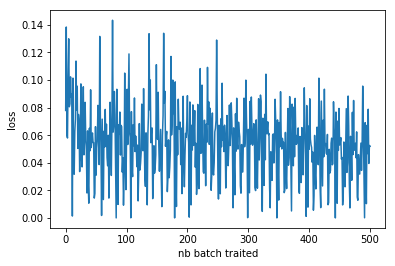

0.052015677094459534
Traitement effectué en 10.158796548843384 secondes.

DEN mu =  0.7  lr =  0.0
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


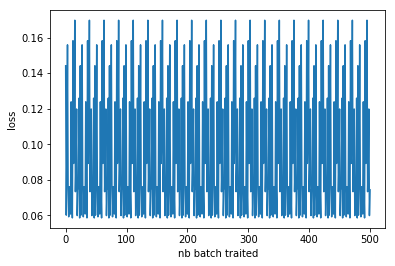

0.07435066252946854
Traitement effectué en 10.131650686264038 secondes.

DEN mu =  0.7  lr =  2.5e-05
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


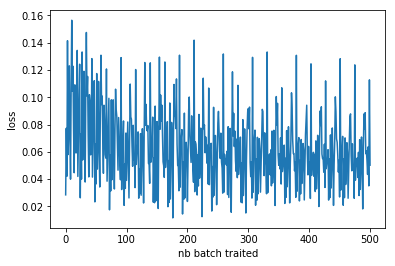

0.05020013824105263
Traitement effectué en 10.178602695465088 secondes.

DEN mu =  0.7  lr =  5e-05
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


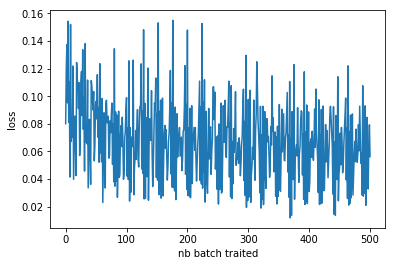

0.05625586211681366
Traitement effectué en 10.158426523208618 secondes.

DEN mu =  0.7  lr =  7.5e-05
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


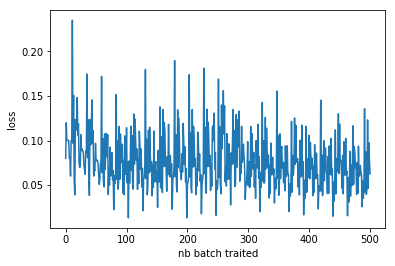

0.0625835582613945
Traitement effectué en 10.122402429580688 secondes.

DEN mu =  0.7  lr =  0.0001
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


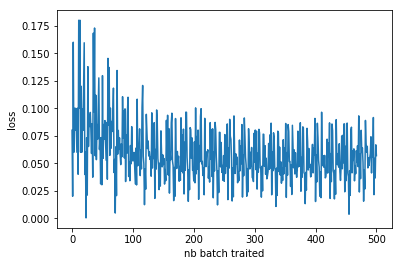

0.05698211118578911
Traitement effectué en 9.84228515625 secondes.

DEN mu =  0.7  lr =  0.000125
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


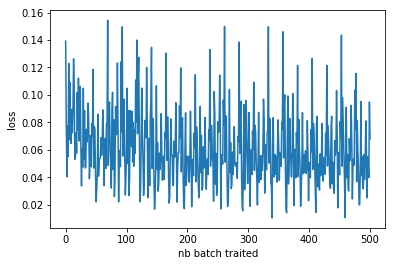

0.06786263734102249
Traitement effectué en 10.133850812911987 secondes.

DEN mu =  0.7  lr =  0.00015
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


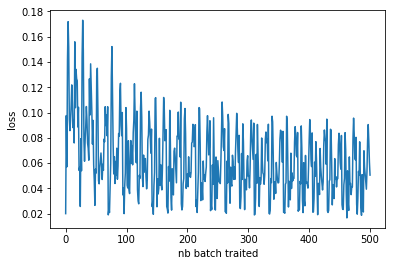

0.05049273371696472
Traitement effectué en 10.279343605041504 secondes.

DEN mu =  0.7  lr =  0.000175
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


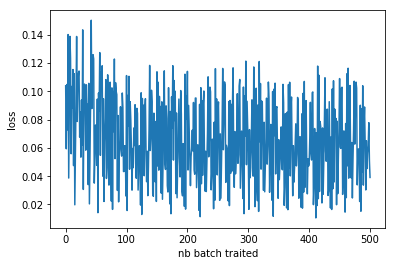

0.03911207616329193
Traitement effectué en 10.177087545394897 secondes.

DEN mu =  0.7  lr =  0.0002
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


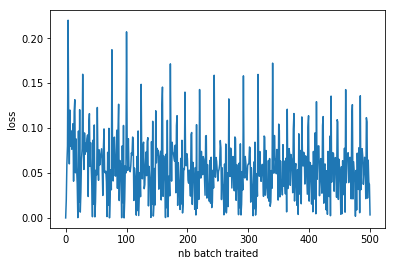

0.0033839119132608175
Traitement effectué en 10.181097030639648 secondes.

DEN mu =  0.7  lr =  0.000225
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


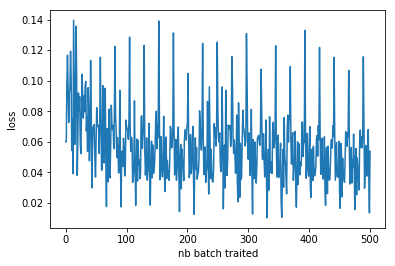

0.05387052893638611
Traitement effectué en 10.124377965927124 secondes.

DEN mu =  0.7  lr =  0.00025
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


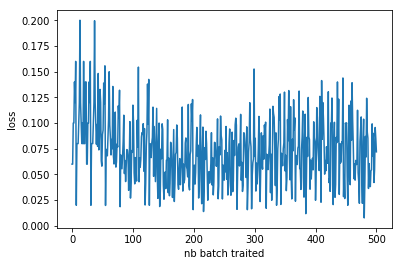

0.07199113070964813
Traitement effectué en 9.940712451934814 secondes.

DEN mu =  0.7  lr =  0.000275
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


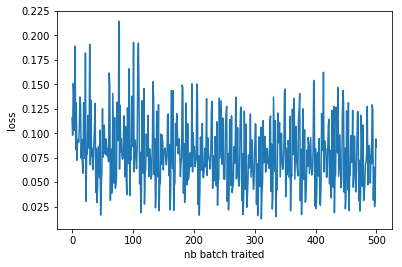

0.08620759844779968
Traitement effectué en 10.098579168319702 secondes.

DEN mu =  0.8  lr =  0.0
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


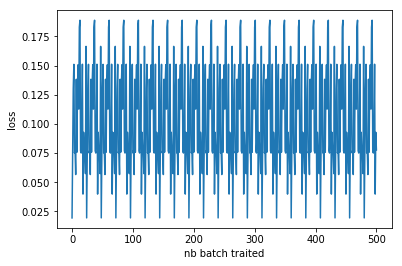

0.07777402549982071
Traitement effectué en 10.14579439163208 secondes.

DEN mu =  0.8  lr =  2.5e-05
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


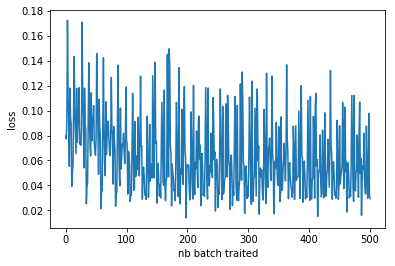

0.029430808499455452
Traitement effectué en 10.225094079971313 secondes.

DEN mu =  0.8  lr =  5e-05
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


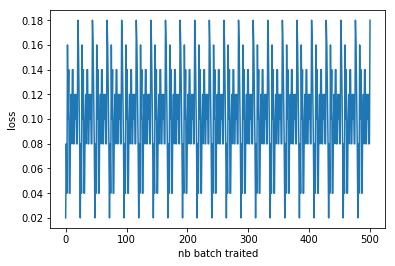

0.18000000715255737
Traitement effectué en 10.118070840835571 secondes.

DEN mu =  0.8  lr =  7.5e-05
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


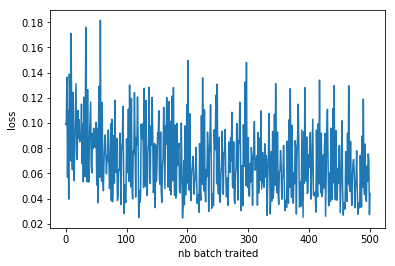

0.044030189514160156
Traitement effectué en 10.016295671463013 secondes.

DEN mu =  0.8  lr =  0.0001
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


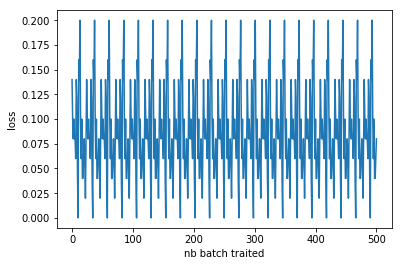

0.07999999821186066
Traitement effectué en 10.002460956573486 secondes.

DEN mu =  0.8  lr =  0.000125
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


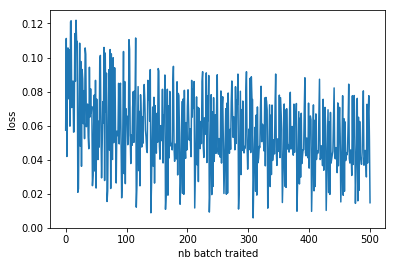

0.014784916304051876
Traitement effectué en 10.117465019226074 secondes.

DEN mu =  0.8  lr =  0.00015
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


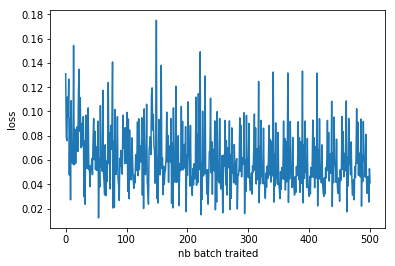

0.041204337030649185
Traitement effectué en 10.20456600189209 secondes.

DEN mu =  0.8  lr =  0.000175
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


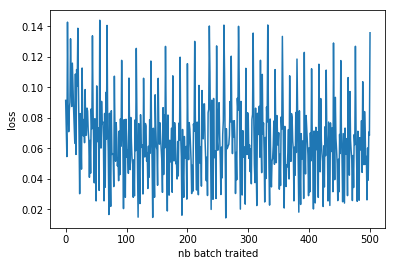

0.1357957124710083
Traitement effectué en 10.199720621109009 secondes.

DEN mu =  0.8  lr =  0.0002
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


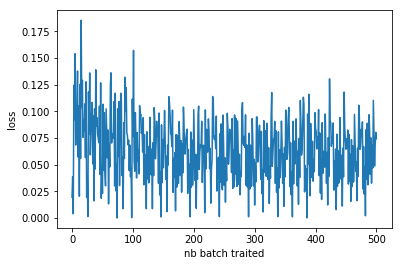

0.074254110455513
Traitement effectué en 10.175178289413452 secondes.

DEN mu =  0.8  lr =  0.000225
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


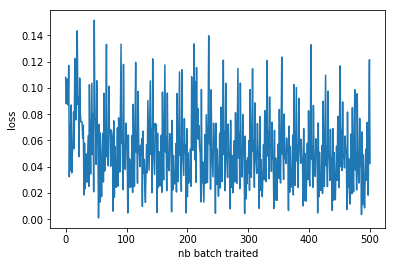

0.04246852919459343
Traitement effectué en 10.153996706008911 secondes.

DEN mu =  0.8  lr =  0.00025
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


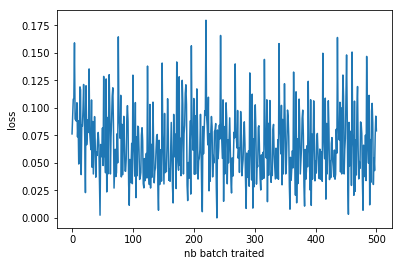

0.07916289567947388
Traitement effectué en 10.078157186508179 secondes.

DEN mu =  0.8  lr =  0.000275
Iteration 0 
Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


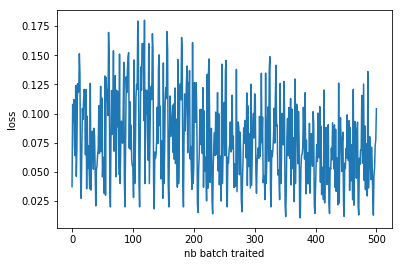

0.10413336008787155
Traitement effectué en 10.064938068389893 secondes.

DEN mu =  0.9  lr =  0.0
Iteration 0 
Iteration 500 
Iteration 1000 


In [ ]:


losses = []
times = []

for i_mu in list(np.arange(0, 1.1, .1)):
    for i_lr in list(np.arange(0, .0003, .000025)):
        
        log_start = time.time()
        
        simple_net = nn.Sequential(nn.Linear(784, 312),
                           nn.ReLU(),
                           nn.Linear(312, 128),
                           nn.ReLU(),
                           nn.Linear(128, 1),
                           nn.ReLU())
        simple_net.cuda()

        print("DEN mu = ", i_mu, " lr = ",i_lr)
        den = DEN(simple_net, mu = i_mu, lr = i_lr)
        den.cuda()

        lossHisto = []
        ite = 5000
        
        for i,(x, y) in enumerate(itertools.cycle(mnist_variation_train_set_loader)):
            
            if i > ite :
                break
            if i%(ite/10) == 0:
                print("Iteration", i, "\r")
            

            x = Variable(x)
            x = x.cuda()
            y = Variable((y == 0).float())
            y = y.cuda()

            loss = den.trainFirst(x,y)

            if i%(10) == 0:
                lossHisto.append(loss.data.mean())

        plt.plot(lossHisto)
        plt.ylabel('loss')
        plt.xlabel('nb batch traited')
        print("DEN mu = ", i_mu, " lr = ",i_lr)
        plt.show()
        print(lossHisto[-1])
        losses.append(lossHisto[-1])
        log_stop = str(time.time() - log_start)
        times.append(log_stop)
        print("Traitement effectué en " + str(log_stop) + " secondes.\n")

In [29]:
print(min(losses))

0.019999999552965164


## Expérimentations

Basé sur le code fourni dans [la documentation de PyTorch](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
losses = []

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    saving_loss = 0.0
    for i, data in enumerate(cifar10_train_loader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        saving_loss += loss.data[0]
        if i % 200 == 199:    # save every 200 mini-batches
            losses.append(saving_loss / 200)
            saving_loss = 0.0
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

plt.plot(losses)
plt.show()

In [ ]:
dataiter = iter(cifar10_test_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
outputs = net(Variable(images))

In [ ]:
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [ ]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
net.cuda()

In [ ]:
inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())